<a href="https://colab.research.google.com/github/finlaycm/tensorflow_tumor_detection/blob/master/part6_new_newslide_evaluation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
colab_root_dir = '/content'
drive_dir='/content/drive'
project_root_dir = os.path.join(drive_dir,'My Drive','deeplearning','cancer_classification')
eval_dir = os.path.join(project_root_dir,'eval')
drive.mount(drive_dir)
test_slides = ['tumor_094','tumor_096','tumor_019','tumor_016','tumor_031','tumor_084']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


In [ ]:
#Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.0.0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2 as cv
import json
from google.colab import drive
import pathlib
import shutil
import random
import time
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Input, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

print(tf.__version__)
print(openslide_version)

2.0.0
3.4.1


In [ ]:
test_slides = ['tumor_094','tumor_096','tumor_019','tumor_016','tumor_031','tumor_084']
slide_dir=os.path.join(project_root_dir,'myslides')
slide_files = [os.path.join(slide_dir,s) for s in os.listdir(slide_dir) if pathlib.Path(s).stem in test_slides ]
mask_dir=os.path.join(project_root_dir,'mymasks')
mask_files = [os.path.join(mask_dir,m) for m in os.listdir(mask_dir) if pathlib.Path(m).stem.replace('_mask','') in test_slides ]
slide_files

['/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_031.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_019.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_096.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_094.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_084.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_016.tif']

In [ ]:
def copy_files(slide_path):
  global slide_name, mask_path, patches_folder_name,predictions_path
  slide_name = pathlib.Path(slide_path).stem
  mask_path = [m for m in mask_files if slide_name in m][0]
  patches_folder_path = os.path.join(eval_dir,slide_name,'patches_'+slide_name+'.zip')
  patches_folder_name = 'patches_'+slide_name
  predictions_path = os.path.join(eval_dir,slide_name,'pred_'+slide_name+'.pkl')
  patches_locator_name = patches_folder_name+'_locators.npy'
  patches_locators_path = os.path.join(eval_dir,slide_name,patches_locator_name)

  shutil.copy(patches_folder_path,colab_root_dir)
  shutil.copy(predictions_path,colab_root_dir)
  shutil.copy(patches_folder_path,colab_root_dir)
  shutil.copy(patches_locators_path,colab_root_dir)
  !unzip -q -o $patches_folder_name -d $patches_folder_name

def read_slide(slide_path, level, x = 0, y = 0, width=None, height=None, as_float=False, show=False):
    slide = open_slide(slide_path)
    if not width: width=slide.level_dimensions[level][0]
    if not height: height=slide.level_dimensions[level][1]
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    if '_mask.tif' in str(slide_path):
      im = im[:,:,0]
    if show:
      plt.imshow(im)
      plt.show()
    return im


In [ ]:
# def predictions_map(predictions_df,threshold):
#   w,h =slide.level_dimensions[0]
#   pred_pos = predictions_df[predictions_df['prediction']>=threshold][['x','y']].sort_values(by=['x','y']).reset_index(drop=True)
#   print(pred_pos.shape)
#   heatmap = np.zeros((h//256,w//256,3),dtype=int)*[0,0,255]
#   for x in range(0,w,256):
#     for y in range(0,h,256):
#       if not pred_pos[(pred_pos['x']==x) & (pred_pos['y']==y)].empty:
#         heatmap[y//256,x//256] = [255,0,0]
#   return heatmap
# heatmap = predictions_map(predictions_df,threshold=0.5)
# plt.imshow(heatmap)


In [ ]:
def lesion_maps(predictions_df,threshold):
  w,h =slide.level_dimensions[0]
  pred_pos = predictions_df[predictions_df['prediction']>=threshold][['x','y']].sort_values(by=['x','y']).reset_index(drop=True)
  heatmap = np.asarray(Image.new('RGB', (w//256,h//256), color=(0, 0, 255))).copy()
  for x, y in pred_pos.values:
    heatmap[y//256,x//256] = [255,0,0]
  true_pos = predictions_df[predictions_df['truth']==1][['x','y']].sort_values(by=['x','y']).reset_index(drop=True)
  pred_pos = predictions_df[predictions_df['prediction']>threshold][['x','y']].sort_values(by=['x','y']).reset_index(drop=True)
  

  ##Superimposed image
  img = read_slide(slide_path,level=7)
  heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
  heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
  superimposed_img = (heatmap *0.4 + img)
  superimposed_img /= superimposed_img.max()
  

  
  ###Lesion region
  xmin = true_pos['x'].min()
  ymin = true_pos['y'].min()
  w = true_pos['x'].max() - xmin + 256
  h = true_pos['y'].max() - ymin + 256
  lesion_heatmap = np.asarray(Image.new('RGB', (w//256,h//256), color=(0, 0, 255))).copy()
  for x, y in pred_pos.values:
    if (y>=ymin) &  (y-ymin < h) & (x>=xmin) & (x-xmin < w):
      try:
        lesion_heatmap[(y-ymin)//256,(x-xmin)//256] = [255,0,0]
      except: 
        print(lesion_heatmap.shape,h//256,w/256,(y-ymin)//256,(x-xmin)//256)
  for lv in range(8):
    if w*h//2**(2*lv) >1e6:continue
    else: 
      level = lv
      break
  lesionmask = read_slide(mask_path,level= level , x = xmin, y=ymin, width = w//2**level, height = h//2**level)
  lesion = read_slide(slide_path,level= level , x = xmin, y=ymin, width = w//2**level, height = h//2**level)

  #####Superimposed image around lesion area
  lesion_heatmap = cv.resize(lesion_heatmap, (lesion.shape[1], lesion.shape[0]))
  lesion_heatmap = cv.applyColorMap(lesion_heatmap, cv.COLORMAP_JET)
  lesion_heatmap = cv.applyColorMap(lesion_heatmap, cv.COLORMAP_JET)
  superimposed_lesion = (lesion_heatmap *0.4 + lesion)
  superimposed_lesion /= superimposed_lesion.max()
  return img,heatmap,superimposed_img,lesion,lesionmask,lesion_heatmap,superimposed_lesion


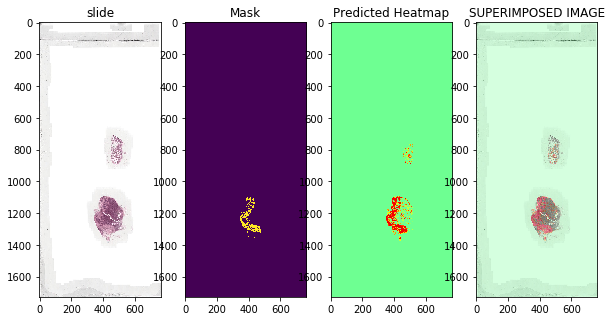

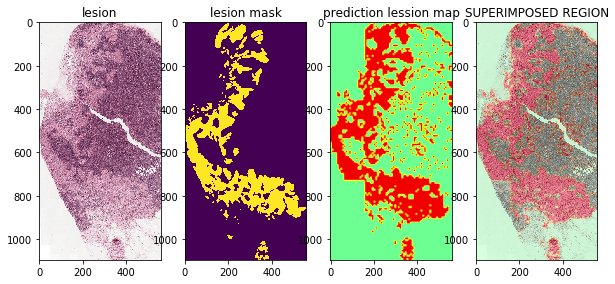

In [ ]:
slide_name = 'tumor_031'
slide_path = [s for s in slide_files if slide_name in s][0]
copy_files(slide_path)
slide = open_slide(slide_path)
predictions_df = pd.read_pickle(predictions_path)
img,heatmap,superimposed_img,lesion,lesionmask,lesion_heatmap,superimposed_lesion= lesion_maps(predictions_df,threshold=0.9)
fig,axs = plt.subplots(nrows=1, ncols = 4, figsize = (10,20))
axs[0].imshow(img)
axs[0].set_title('slide')
mask = read_slide(mask_path,level=7)
axs[1].imshow(mask)
axs[1].set_title('Mask')
axs[2].imshow(heatmap)
axs[2].set_title('Predicted Heatmap')
axs[3].imshow(superimposed_img)
axs[3].set_title('SUPERIMPOSED IMAGE')
plt.show()
fig,axs = plt.subplots(nrows=1, ncols = 4, figsize = (10,20))
axs[0].imshow(lesion)
axs[0].set_title('lesion')
axs[1].imshow(lesionmask)
axs[1].set_title('lesion mask')
axs[2].imshow(lesion_heatmap)
axs[2].set_title('prediction lession map')
axs[3].imshow(superimposed_lesion)
axs[3].set_title('SUPERIMPOSED REGION')
plt.show()



In [ ]:
tp = predictions_df[predictions_df['truth']==1]['prediction'].apply(lambda x: 1 if x > 0.9 else 0).sum()
tn = predictions_df[predictions_df['truth']==0]['prediction'].apply(lambda x: 1 if x <= 0.9 else 0).sum()
fp = predictions_df[predictions_df['truth']==0]['prediction'].apply(lambda x: 1 if x > 0.9 else 0).sum()
fn = predictions_df[predictions_df['truth']==1]['prediction'].apply(lambda x: 1 if x <= 0.9 else 0).sum()
predictions_df.shape, tp, tn, fp, fn


((7936, 7), 2162, 4315, 1137, 322)